In [ ]:
# 解压数据集
# !unzip -oq /home/aistudio/data/data100477/常规赛：PALM眼底彩照中黄斑中央凹定位.zip
# !rm -rf __MACOSX

In [1]:
import blackhole.dataframe as pd  # 数据读取
import paddle.vision.transforms as T  # 数据增强
import matplotlib.pyplot as plt
import paddle
import cv2
import numpy as np

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [ ]:
# 我的测试
file_path='常规赛：PALM眼底彩照中黄斑中央凹定位/Train/fundus_image/'
# file_path='常规赛：PALM眼底彩照中黄斑中央凹定位/PALM-Testing400-Images/'
# file_name='H0001.jpg'
list_=os.listdir(file_path)
print(len(list_),list_[0])
shapes=[]
for f in list_:
    img=cv2.imread(file_path+f,-1)
    a=img.shape
    if(shapes.count(a)==0):
        shapes.append(a)
print(shapes)
# plt.imshow(img[:,:,[2,1,0]])

800 P0198.jpg
[(2056, 2124, 3), (1444, 1444, 3)]


In [2]:
# 查看数据标签
df=pd.read_excel('常规赛：PALM眼底彩照中黄斑中央凹定位/Train/Fovea_Location_train.xlsx')
df.head(1)
# print(type(df))

,imgName,Fovea_X,Fovea_Y
0,H0001.jpg,743.96,790.54


In [3]:
# 计算标签的均值和标准差，用于标签的归一化
key_pts_values = df.values[:,1:] # 取出标签信息
data_mean = key_pts_values.mean() # 计算均值
data_std = key_pts_values.std() # 计算标准差

print('标签的均值为:', data_mean)
print('标签的标准差为:', data_std)

标签的均值为: 1085.6073687500023
标签的标准差为: 183.5345073716085


In [4]:
# 数据增强：调整图像大小Resize、随机位置裁剪RandomCrop、灰度化图片GrayNormalize、变更图片通道ToCHW
import paddle.vision.transforms.functional as F

# 调整图像大小
class Resize(object):
    # 将输入图像调整为指定大小
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, data):
        image = data[0]    # 获取图片
        key_pts = data[1]  # 获取标签

        image_copy = np.copy(image)      
        key_pts_copy = np.copy(key_pts)

        h, w = image_copy.shape[:2]

        new_h, new_w = self.output_size,self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = F.resize(image_copy, (new_h, new_w))
        
        # scale the pts, too
        key_pts_copy[::2] = key_pts_copy[::2] * new_w / w
        key_pts_copy[1::2] = key_pts_copy[1::2] * new_h / h

        return img, key_pts_copy

# 随机位置裁剪
class RandomCrop(object):
    # 随机位置裁剪输入的图像
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, data):
        image = data[0]
        key_pts = data[1]

        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        h, w = image_copy.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image_copy = image_copy[top: top + new_h,
                      left: left + new_w]

        key_pts_copy[::2] = key_pts_copy[::2] - left
        key_pts_copy[1::2] = key_pts_copy[1::2] - top



        return image_copy, key_pts_copy

# 图片灰度化
class GrayNormalize(object):
    # 将图片变为灰度图，并将其值放缩到[0, 1]
    # 将 label 放缩到 [-1, 1] 之间
    def __call__(self, data):
        image = data[0]   # 获取图片
        key_pts = data[1] # 获取标签
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # 灰度化图片
        gray_scale = paddle.vision.transforms.Grayscale(num_output_channels=3)
        image_copy = gray_scale(image_copy)
        
        # 将图片值放缩到 [0, 1]
        image_copy = (image_copy-127.5) / 127.5
        
        # 将坐标点放缩到 [-1, 1]
        mean = data_mean # 获取标签均值
        std = data_std   # 获取标签标准差

        key_pts_copy = (key_pts_copy - mean)/std

        return image_copy, key_pts_copy

# 变更图片通道
class ToCHW(object):
    # 将图像的格式由HWC改为CHW
    def __call__(self, data):
        image = data[0]
        key_pts = data[1]

        transpose = T.Transpose((2, 0, 1)) # 改为CHW
        image = transpose(image)
        
        return image, key_pts

In [5]:
# 使用自定义类进行数据预处理
data_transform = T.Compose([
                        Resize(240),   # 240 1444
                        RandomCrop(224),
                        GrayNormalize(),
                        ToCHW(),
                         ])
data_transform2 = T.Compose([
                        Resize(240),    # 240 1444
                        GrayNormalize(),
                        ToCHW(),
                        ])

In [ ]:
# 使用飞桨的数据增强
import paddle.vision.transforms as T
train_transform = T.Compose([
                        T.Resize(size=[240,240]),    # 压缩图像大小 1444
                        # T.CenterCrop(1440), # 保持图片中心不变并进行裁剪
                        T.ColorJitter(0.1, 0.1, 0.1, 0.1), #　随机调整图像的亮度，对比度，饱和度和色调。
                        T.RandomVerticalFlip(0.3),  # 基于概率来执行图片的垂直翻转。
                        T.RandomHorizontalFlip(0.3),  # 基于概率来执行图片的水平翻转。
                        T.RandomRotation(30),  # 随机旋转
                        T.Normalize(mean=[127.5, 127.5, 127.5],std=[127.5, 127.5, 127.5],data_format='HWC'),  # 归一化
                        T.ToTensor(),
                        ])
val_transform=T.Compose([
                        T.Resize(size=[240,240]),  # 1440
                        T.Normalize(mean=[127.5, 127.5, 127.5],std=[127.5, 127.5, 127.5],data_format='HWC'),
                        T.ToTensor(),
                        ])

In [6]:
# 自定义数据集
path='常规赛：PALM眼底彩照中黄斑中央凹定位/Train/fundus_image/'
df=df.sample(frac=1)
image_list=[]
label_listx=[]
label_listy=[]

for i in range(len(df)):
        image_list.append(path+df['imgName'][i])
        label_listx.append(df['Fovea_X'][i])
        label_listy.append(df['Fovea_Y'][i])

In [7]:
import os
test_path='常规赛：PALM眼底彩照中黄斑中央凹定位/PALM-Testing400-Images'
test_list=[]
test_labelx=[]
test_labely=[]

list = os.listdir(test_path)  # 列出文件夹下所有的目录与文件
for i in range(0, len(list)):
    path = os.path.join(test_path, list[i])
    test_list.append(path)
    test_labelx.append(0)
    test_labely.append(0)

In [8]:
# 定义数据集类
class dataset(paddle.io.Dataset):
    def __init__(self,img_list,label_listx,label_listy,transform=None,transform2=None,mode='train'):

        self.image=img_list
        self.labelx=label_listx
        self.labely=label_listy
        self.mode=mode
        self.transform=transform
        self.transform2=transform2
    def load_img(self, image_path):

        img=cv2.imread(image_path,1)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        return img


    def __getitem__(self,index):
        img = self.load_img(self.image[index])
        labelx = self.labelx[index]
        labely = self.labely[index]
        img_size=img.shape

        if self.transform:
            if self.mode=='train':
                img, label = self.transform([img, [labelx,labely]])
            else:
                img, label = self.transform2([img, [labelx,labely]])

        label=np.array(label,dtype='float32')
        img=np.array(img,dtype='float32')
        return img,label

    def __len__(self):
        return len(self.image)

In [9]:
# 训练集、验证集、测试集
radio=0.8
train_list=image_list[:int(len(image_list)*radio)]
train_labelx=label_listx[:int(len(label_listx)*radio)]
train_labely=label_listy[:int(len(label_listy)*radio)]


val_list=image_list[int(len(image_list)*radio):]
val_labelx=label_listx[int(len(label_listx)*radio):]
val_labely=label_listy[int(len(label_listy)*radio):]


train_ds=dataset(train_list,train_labelx,train_labely,data_transform,data_transform2,'train')
val_ds=dataset(val_list,val_labelx,val_labely,data_transform,data_transform2,'valid')
test_ds=dataset(test_list,test_labelx,test_labely,data_transform,data_transform2,'test')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


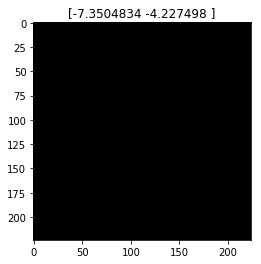

In [ ]:
# 查看图片
for i,data in enumerate(train_ds):
    
    img,label=data

    img=img.transpose([1,2,0])
    print(img.shape)
    
    plt.title(label)
    plt.imshow(img)
    

    if i==0:
        break

In [10]:
# 前向网络构建
class MyNet1(paddle.nn.Layer):
    def __init__(self,num_classes=2):
        super(MyNet1,self).__init__()
        self.net=paddle.vision.resnet152(pretrained=True)

        self.fc1=paddle.nn.Linear(1000,512)
        self.relu=paddle.nn.ReLU()
        self.fc2=paddle.nn.Linear(512,num_classes)

    def forward(self,inputs):
        out=self.net(inputs)

        out=self.fc1(out)
        out=self.relu(out)
        out=self.fc2(out)

        return out

class MyNet2(paddle.nn.Layer):
    def __init__(self):
        super(MyNet2, self).__init__()
        self.resnet = paddle.vision.resnet50(pretrained=True, num_classes=0) # remove final fc 输出为[?, 2048, 1, 1]
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(2048, 512)
        self.linear_2 = paddle.nn.Linear(512, 256)
        self.linear_3 = paddle.nn.Linear(256, 2)
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
    
    def forward(self, inputs):

        y = self.resnet(inputs)
        y = self.flatten(y)
        y = self.linear_1(y)
        y = self.linear_2(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear_3(y)
        y = paddle.nn.functional.sigmoid(y)

        return y

class MyNet3(paddle.nn.Layer):
    def __init__(self,num_classes=2):
        super(MyNet3,self).__init__()
        self.net=paddle.vision.resnet152(pretrained=True)

        self.fc1=paddle.nn.Linear(1000,2000)
        self.relu=paddle.nn.ReLU()
        self.dropout1 = paddle.nn.Dropout(0.2)
        self.fc2=paddle.nn.Linear(2000,num_classes)

    def forward(self,inputs):
        out=self.net(inputs)

        out=self.fc1(out)
        out=self.relu(out)
        out = self.dropout1(out)
        out=self.fc2(out)

        return out

In [ ]:
# 自定义损失函数和相关类
from sklearn.metrics.pairwise import euclidean_distances 
import paddle.nn as nn
# 损失函数
def cal_coordinate_Loss(logit, label, alpha = 0.5):
    """
    logit: shape [batch, ndim]
    label: shape [batch, ndim]
    ndim = 2 represents coordinate_x and coordinaate_y
    alpha: weight for MSELoss and 1-alpha for ED loss
    return: combine MSELoss and ED Loss for x and y, shape [batch, 1]
    """
    alpha = alpha
    mse_loss = nn.MSELoss(reduction='mean')

    mse_x = mse_loss(logit[:,0],label[:,0])
    mse_y = mse_loss(logit[:,1],label[:,1])
    mse_l = 0.5*(mse_x + mse_y)
    # print('mse_l', mse_l)

    ed_loss = []
    # print(logit.shape[0])
    for i in range(logit.shape[0]):
        logit_tmp = logit[i,:].numpy()
        label_tmp = label[i,:].numpy()
        # print('cal_coordinate_loss_ed', logit_tmp, label_tmp)        
        ed_tmp = euclidean_distances([logit_tmp], [label_tmp])
        # print('ed_tmp:', ed_tmp[0][0])
        ed_loss.append(ed_tmp)
    
    ed_l = sum(ed_loss)/len(ed_loss)
    # print('ed_l', ed_l)
    # print('alpha', alpha)
    loss = alpha * mse_l + (1-alpha) * ed_l
    # print('loss in function', loss)
    return loss

class SelfDefineLoss(paddle.nn.Layer):
   """
   1. 继承paddle.nn.Layer
   """
   def __init__(self):
       """
       2. 构造函数根据自己的实际算法需求和使用需求进行参数定义即可
       """
       super(SelfDefineLoss, self).__init__()

   def forward(self, input, label):
       """
       3. 实现forward函数，forward在调用时会传递两个参数：input和label
           - input：单个或批次训练数据经过模型前向计算输出结果
           - label：单个或批次训练数据对应的标签数据
           接口返回值是一个Tensor，根据自定义的逻辑加和或计算均值后的损失
       """
       # 使用Paddle中相关API自定义的计算逻辑
       output = cal_coordinate_Loss(input,label)
       return output

In [11]:
# 异步数据加载
train_loader = paddle.io.DataLoader(train_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=True, num_workers=0)
val_loader = paddle.io.DataLoader(val_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=False, num_workers=0)
test_loader=paddle.io.DataLoader(test_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=False, num_workers=0)

In [12]:
# 模型训练与可视化
from utils import NME
visualdl=paddle.callbacks.VisualDL(log_dir='visual_log')
#定义输入

Batch_size=32    # 每批训练数据的大小
EPOCHS=30    # 训练的总次数
step_each_epoch = len(train_ds)//Batch_size

# 使用 paddle.Model 封装模型
model = paddle.Model(MyNet3())  # num_classes=2

lr = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=3e-4,    # 学习率初始值
                                            #   eta_min=1e-5,    # 学习率最终值，默认0
                                              T_max=step_each_epoch * EPOCHS)

# 定义Adam优化器
optimizer = paddle.optimizer.Adam(learning_rate=lr,
                                weight_decay=1e-4,    # 正则化系数 1e-4
                                parameters=model.parameters())
# 定义损失：SmoothL1Loss
# loss =paddle.nn.SmoothL1Loss()
# loss =SelfDefineLoss()
loss=paddle.nn.MSELoss(reduction='mean')

# 使用自定义metrics
metric = NME()

model.prepare(optimizer=optimizer, loss=loss, metrics=metric)

# model.load('/home/aistudio/work/lup/final')

# 启动模型全流程训练
model.fit(train_loader,  # 训练数据集
          val_loader,   # 评估数据集
          epochs=EPOCHS,       # 训练的总轮次
          batch_size=Batch_size,  # 训练使用的批大小
          save_dir="/home/aistudio/work/lup", #把模型参数、优化器参数保存至自定义的文件夹
          save_freq=1,                    #设定每隔多少个epoch保存模型参数及优化器参数
          verbose=1 ,      # 日志展示形式
          callbacks=[visualdl]
          )  # 设置可视化

W1103 09:17:01.086086   793 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W1103 09:17:01.143574   793 device_context.cc:422] device: 0, cuDNN Version: 7.6.
100%|██████████| 355826/355826 [00:05<00:00, 60144.32it/s]


The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/30


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


step 20/20 [==============================] - loss: 0.7987 - nme: 2.6488 - 2s/step          
save checkpoint at /home/aistudio/work/lup/0
Eval begin...
step 5/5 [==============================] - loss: 0.4149 - nme: 0.9242 - 2s/step
Eval samples: 160
Epoch 2/30
step 20/20 [==============================] - loss: 0.2826 - nme: 0.9553 - 2s/step          
save checkpoint at /home/aistudio/work/lup/1
Eval begin...
step 5/5 [==============================] - loss: 0.1146 - nme: 0.4539 - 2s/step
Eval samples: 160
Epoch 3/30
step 20/20 [==============================] - loss: 0.1658 - nme: 0.5793 - 2s/step          
save checkpoint at /home/aistudio/work/lup/2
Eval begin...
step 5/5 [==============================] - loss: 0.2310 - nme: 0.6559 - 2s/step
Eval samples: 160
Epoch 4/30
step 20/20 [==============================] - loss: 0.1159 - nme: 0.4710 - 2s/step          
save checkpoint at /home/aistudio/work/lup/3
Eval begin...
step 5/5 [==============================] - loss: 0.1429 - nme

In [15]:
# 模型评估
model.load('/home/aistudio/work/lup/6')  # final
result = model.evaluate(val_loader, verbose=1)
print(result)

Eval begin...
step 5/5 [==============================] - loss: 0.0865 - nme: 0.3944 - 2s/step
Eval samples: 160
{'loss': [0.086451456], 'nme': 0.39436783910244433}


In [14]:
# 模型批量评估
model_path="/home/aistudio/work/lup/"
with open('recors/record.txt','w') as f:
    for i in range(30):
        model.load('/home/aistudio/work/lup/'+str(i))
        result = model.evaluate(val_loader, verbose=1)
        print('no.',i,result)
        f.write(str(i)+str(result)+'\n')

Eval begin...
step 5/5 [==============================] - loss: 0.4149 - nme: 0.9242 - 2s/step
Eval samples: 160
no. 0 {'loss': [0.414888], 'nme': 0.924190838912871}
Eval begin...
step 5/5 [==============================] - loss: 0.1146 - nme: 0.4539 - 2s/step
Eval samples: 160
no. 1 {'loss': [0.11456683], 'nme': 0.45386044390660346}
Eval begin...
step 5/5 [==============================] - loss: 0.2310 - nme: 0.6559 - 2s/step
Eval samples: 160
no. 2 {'loss': [0.23095012], 'nme': 0.6559024192799737}
Eval begin...
step 5/5 [==============================] - loss: 0.1429 - nme: 0.5067 - 2s/step
Eval samples: 160
no. 3 {'loss': [0.14291322], 'nme': 0.506718317263575}
Eval begin...
step 5/5 [==============================] - loss: 0.1438 - nme: 0.5093 - 2s/step
Eval samples: 160
no. 4 {'loss': [0.14382368], 'nme': 0.509342147629029}
Eval begin...
step 5/5 [==============================] - loss: 0.1566 - nme: 0.5409 - 2s/step
Eval samples: 160
no. 5 {'loss': [0.1565929], 'nme': 0.540892743

In [16]:
# 进行预测操作
result = model.predict(test_loader)

Predict begin...
step 13/13 [==============================] - 2s/step         
Predict samples: 400


In [17]:
# 获取测试图片尺寸和图片名
test_path='常规赛：PALM眼底彩照中黄斑中央凹定位/PALM-Testing400-Images'
test_size=[]
FileName=[]
for i in range(len(list)):
    path = os.path.join(test_path, list[i])
    img=cv2.imread(path,1)
    test_size.append(img.shape)
    FileName.append(list[i])
test_size=np.array(test_size)

In [18]:
# 输出结果文件
result=np.array(result)
pred=[]
for i in range(len(result[0])):
    pred.extend(result[0][i])
pred=np.array(pred) 

pred = paddle.to_tensor(pred)
out=np.array(pred).reshape(-1,2)

Fovea_X=out[:,0]*data_std+data_mean
Fovea_Y=out[:,1]*data_std+data_mean

Fovea_X=Fovea_X*test_size[:,1]/224
Fovea_Y=Fovea_Y*test_size[:,0]/224

submission = pd.DataFrame(data={
                            "FileName": FileName,
                            "Fovea_X": Fovea_X,
                            "Fovea_Y": Fovea_Y
                        })
submission=submission.sort_values(by='FileName')
submission.to_csv("result.csv", index=False)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
# 合并计算输出
import numpy as np
import blackhole.dataframe as pd
df1=pd.read_csv('result41.958.csv')
df2=pd.read_csv('result41.958.csv')
df3=pd.read_csv('result49.65447.csv')
df4=pd.read_csv('result49.75246.csv')


dfs=[df1,df2,df3,df4]

File_Name=[]
Fovea_X=[]
Fovea_Y=[]
for i in range(len(df1)):
    File_Name.append(dfs[0]['FileName'][i])
    avgx=(sum(np.array(dfs[x]['Fovea_X'][i]) for x in range(len(dfs))))/len(dfs)
    avgy=(sum(np.array(dfs[x]['Fovea_Y'][i]) for x in range(len(dfs))))/len(dfs)
    
    Fovea_X.append(avgx)
    Fovea_Y.append(avgy)
submission = pd.DataFrame(data={
                            "FileName": File_Name,
                            "Fovea_X": Fovea_X,
                            "Fovea_Y":Fovea_Y
                        })
submission=submission.sort_values(by='FileName')
submission.to_csv("result.csv", index=False)